In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import os
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np 
from torchvision.utils import make_grid
import imageio

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
import importlib
try: 
    importlib.reload(utils)
    importlib.reload(generators)
    importlib.reload(trainers)
    print("libs reloaded")
except:
    import utils  
    import generators 
    import trainers
    print("libs imported")
  
#Prostate2D = utils.Prostate2D
VAE = generators.VAE
VAEGAN = generators.VAEGAN
TrainerVAEGAN = trainers.TrainerVAEGAN

libs imported


In [4]:
WORKING_DIR = Path(r"C:\Users\20182371\Documents\TUe\8DM20_CS_Medical_Imaging\DeepLearning_Project")
DATA_DIR = WORKING_DIR / "TrainingData"

PROGRESS_DIR_VAEGAN = WORKING_DIR / "progress_vaegan"
PROGRESS_DIR_VAEGAN.mkdir(parents=True, exist_ok=True)

N = 15
N_train = 15-3
Z_DIM = 256
BATCH_SIZE = 32
N_EPOCHS = 200
DECAY_LR_AFTER = 50
LEARNING_RATE = 1e-3
KLD_ANNEALING_EPOCHS = 50
GAMMA = 1.0
ADA_TARGET = 0.6
ADA_LENGTH = 10_000
ACCUM = 0.5 ** (32 / (10 * 1000))
NO_VALIDATION_PATIENTS = 2
IMAGE_SIZE = (64,64)
TOLERANCE = -1e-8
MINIMUM_VALID_LOSS = 10 
seed=0

exp = str(N_EPOCHS) + '_epochs_' + str(Z_DIM) + "_zdim" + "_ema"
EXPERIMENT_DIR_VAEGAN = PROGRESS_DIR_VAEGAN / exp
EXPERIMENT_DIR_VAEGAN.mkdir(parents=True, exist_ok=True)

def lambda_lr(the_epoch):
    return (
        1.0
        if the_epoch < DECAY_LR_AFTER
        else 1 - float(the_epoch - DECAY_LR_AFTER) / (N_EPOCHS - DECAY_LR_AFTER)
    )

patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]

train_indx, valid_indx = train_test_split(patients, random_state=seed, train_size=N_train)

partition = {
    "train": train_indx,
    "validation": valid_indx,
}

# load training data and create DataLoader with batching and shuffling
train_set = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

# load validation data
valid_set = utils.ProstateMRDataset(partition["validation"], IMAGE_SIZE)
valid_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

In [5]:
OPTIMIZER = lambda parameters, lr : torch.optim.RMSprop(
    parameters,
    lr=lr,
    alpha=0.9,
    eps=1e-8,
    weight_decay=0,
    momentum=0,
    centered=False
)

vaegan_model = VAEGAN(z_dim=Z_DIM, l=2, spade=True).to(device)
net_ema = VAEGAN(z_dim=Z_DIM, l=2, spade=True).to(device)
net_ema.eval()

optimizer_enc = OPTIMIZER(vaegan_model.encoder.parameters(), lr=LEARNING_RATE)
optimizer_gen = OPTIMIZER(vaegan_model.generator.parameters(), lr=LEARNING_RATE)
optimizer_disc = OPTIMIZER(vaegan_model.discriminator.parameters(), lr=LEARNING_RATE)

vaegan_trainer = TrainerVAEGAN(
    net=vaegan_model,
    optimizer_enc=optimizer_enc,
    optimizer_gen=optimizer_gen,
    optimizer_disc=optimizer_disc,
    kld_annealing_epochs=KLD_ANNEALING_EPOCHS,
    progress_dir=EXPERIMENT_DIR_VAEGAN,
    train_loader=train_loader,
    valid_loader=valid_loader,
    CHECKPOINTS_DIR=EXPERIMENT_DIR_VAEGAN,
    TOLERANCE=TOLERANCE, 
    minimum_valid_loss=MINIMUM_VALID_LOSS,
    net_ema = None,
    accum = ACCUM,
    ada_target = ADA_TARGET,
    ada_length = ADA_LENGTH,
    gamma = GAMMA,
    device = device,
    seed = 0,
    early_stopping=False
)

In [7]:
vaegan_trainer.train(N_EPOCHS, lambda_lr=lambda_lr)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #000: Rec_Loss/train = 0.643, KLD/train = 133.827, Discl_Loss/train = 1.634, Adv_Loss/train = 0.972 | Rec_Loss/valid = 0.469, KLD/valid = 10.536, Discl_Loss/valid = 1.470, Adv_Loss/valid = 0.042


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #001: Rec_Loss/train = 0.490, KLD/train = 10.979, Discl_Loss/train = 1.533, Adv_Loss/train = 0.430 | Rec_Loss/valid = 0.454, KLD/valid = 5.438, Discl_Loss/valid = 1.604, Adv_Loss/valid = 0.169


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #002: Rec_Loss/train = 0.497, KLD/train = 5.404, Discl_Loss/train = 1.525, Adv_Loss/train = 0.363 | Rec_Loss/valid = 0.478, KLD/valid = 2.869, Discl_Loss/valid = 1.487, Adv_Loss/valid = 0.742


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #003: Rec_Loss/train = 0.488, KLD/train = 2.842, Discl_Loss/train = 1.549, Adv_Loss/train = 0.588 | Rec_Loss/valid = 0.440, KLD/valid = 1.694, Discl_Loss/valid = 1.616, Adv_Loss/valid = 0.587


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #004: Rec_Loss/train = 0.397, KLD/train = 1.792, Discl_Loss/train = 1.520, Adv_Loss/train = 0.606 | Rec_Loss/valid = 0.362, KLD/valid = 1.438, Discl_Loss/valid = 1.632, Adv_Loss/valid = 0.628


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #005: Rec_Loss/train = 0.342, KLD/train = 1.446, Discl_Loss/train = 1.439, Adv_Loss/train = 0.528 | Rec_Loss/valid = 0.337, KLD/valid = 1.005, Discl_Loss/valid = 1.484, Adv_Loss/valid = 0.582


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #006: Rec_Loss/train = 0.336, KLD/train = 1.117, Discl_Loss/train = 1.326, Adv_Loss/train = 0.527 | Rec_Loss/valid = 0.456, KLD/valid = 0.807, Discl_Loss/valid = 1.561, Adv_Loss/valid = 1.189


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #007: Rec_Loss/train = 0.328, KLD/train = 0.835, Discl_Loss/train = 1.282, Adv_Loss/train = 0.382 | Rec_Loss/valid = 0.342, KLD/valid = 0.575, Discl_Loss/valid = 1.331, Adv_Loss/valid = 0.638


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #008: Rec_Loss/train = 0.328, KLD/train = 0.645, Discl_Loss/train = 1.258, Adv_Loss/train = 0.422 | Rec_Loss/valid = 0.322, KLD/valid = 0.556, Discl_Loss/valid = 1.261, Adv_Loss/valid = 0.621


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #009: Rec_Loss/train = 0.328, KLD/train = 0.581, Discl_Loss/train = 1.262, Adv_Loss/train = 0.408 | Rec_Loss/valid = 0.325, KLD/valid = 0.457, Discl_Loss/valid = 1.302, Adv_Loss/valid = 0.343


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #010: Rec_Loss/train = 0.328, KLD/train = 0.466, Discl_Loss/train = 1.204, Adv_Loss/train = 0.490 | Rec_Loss/valid = 0.416, KLD/valid = 0.340, Discl_Loss/valid = 1.362, Adv_Loss/valid = 0.794


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #011: Rec_Loss/train = 0.333, KLD/train = 0.386, Discl_Loss/train = 1.163, Adv_Loss/train = 0.448 | Rec_Loss/valid = 0.490, KLD/valid = 0.409, Discl_Loss/valid = 1.469, Adv_Loss/valid = 0.694


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #012: Rec_Loss/train = 0.334, KLD/train = 0.370, Discl_Loss/train = 1.138, Adv_Loss/train = 0.389 | Rec_Loss/valid = 0.347, KLD/valid = 0.254, Discl_Loss/valid = 1.201, Adv_Loss/valid = 0.469


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #013: Rec_Loss/train = 0.326, KLD/train = 0.323, Discl_Loss/train = 1.145, Adv_Loss/train = 0.438 | Rec_Loss/valid = 0.341, KLD/valid = 0.273, Discl_Loss/valid = 1.217, Adv_Loss/valid = 0.454


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #014: Rec_Loss/train = 0.328, KLD/train = 0.288, Discl_Loss/train = 1.144, Adv_Loss/train = 0.414 | Rec_Loss/valid = 0.331, KLD/valid = 0.190, Discl_Loss/valid = 1.317, Adv_Loss/valid = 0.567


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #015: Rec_Loss/train = 0.323, KLD/train = 0.275, Discl_Loss/train = 1.114, Adv_Loss/train = 0.425 | Rec_Loss/valid = 0.379, KLD/valid = 0.231, Discl_Loss/valid = 1.267, Adv_Loss/valid = 0.430


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #016: Rec_Loss/train = 0.313, KLD/train = 0.253, Discl_Loss/train = 1.104, Adv_Loss/train = 0.341 | Rec_Loss/valid = 0.336, KLD/valid = 0.269, Discl_Loss/valid = 1.331, Adv_Loss/valid = 0.829


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #017: Rec_Loss/train = 0.330, KLD/train = 0.229, Discl_Loss/train = 1.129, Adv_Loss/train = 0.388 | Rec_Loss/valid = 0.307, KLD/valid = 0.163, Discl_Loss/valid = 1.246, Adv_Loss/valid = 0.437


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #018: Rec_Loss/train = 0.311, KLD/train = 0.221, Discl_Loss/train = 1.057, Adv_Loss/train = 0.421 | Rec_Loss/valid = 0.335, KLD/valid = 0.163, Discl_Loss/valid = 1.260, Adv_Loss/valid = 0.382


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #019: Rec_Loss/train = 0.322, KLD/train = 0.201, Discl_Loss/train = 1.087, Adv_Loss/train = 0.389 | Rec_Loss/valid = 0.336, KLD/valid = 0.134, Discl_Loss/valid = 1.253, Adv_Loss/valid = 0.745


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #020: Rec_Loss/train = 0.325, KLD/train = 0.189, Discl_Loss/train = 1.068, Adv_Loss/train = 0.385 | Rec_Loss/valid = 0.311, KLD/valid = 0.139, Discl_Loss/valid = 1.227, Adv_Loss/valid = 0.282


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #021: Rec_Loss/train = 0.330, KLD/train = 0.184, Discl_Loss/train = 1.067, Adv_Loss/train = 0.488 | Rec_Loss/valid = 0.300, KLD/valid = 0.146, Discl_Loss/valid = 1.228, Adv_Loss/valid = 0.401


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #022: Rec_Loss/train = 0.309, KLD/train = 0.167, Discl_Loss/train = 1.042, Adv_Loss/train = 0.350 | Rec_Loss/valid = 0.346, KLD/valid = 0.112, Discl_Loss/valid = 1.212, Adv_Loss/valid = 0.256


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #023: Rec_Loss/train = 0.308, KLD/train = 0.157, Discl_Loss/train = 1.039, Adv_Loss/train = 0.377 | Rec_Loss/valid = 0.303, KLD/valid = 0.112, Discl_Loss/valid = 1.174, Adv_Loss/valid = 0.236


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #024: Rec_Loss/train = 0.323, KLD/train = 0.149, Discl_Loss/train = 1.023, Adv_Loss/train = 0.442 | Rec_Loss/valid = 0.303, KLD/valid = 0.116, Discl_Loss/valid = 1.220, Adv_Loss/valid = 0.529


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #025: Rec_Loss/train = 0.325, KLD/train = 0.148, Discl_Loss/train = 1.028, Adv_Loss/train = 0.413 | Rec_Loss/valid = 0.334, KLD/valid = 0.102, Discl_Loss/valid = 1.188, Adv_Loss/valid = 0.649


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #026: Rec_Loss/train = 0.315, KLD/train = 0.143, Discl_Loss/train = 1.000, Adv_Loss/train = 0.381 | Rec_Loss/valid = 0.338, KLD/valid = 0.104, Discl_Loss/valid = 1.240, Adv_Loss/valid = 0.259


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #027: Rec_Loss/train = 0.322, KLD/train = 0.133, Discl_Loss/train = 1.014, Adv_Loss/train = 0.427 | Rec_Loss/valid = 0.341, KLD/valid = 0.100, Discl_Loss/valid = 1.302, Adv_Loss/valid = 0.491


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #028: Rec_Loss/train = 0.313, KLD/train = 0.131, Discl_Loss/train = 1.013, Adv_Loss/train = 0.412 | Rec_Loss/valid = 0.372, KLD/valid = 0.090, Discl_Loss/valid = 1.272, Adv_Loss/valid = 0.868


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #029: Rec_Loss/train = 0.326, KLD/train = 0.127, Discl_Loss/train = 1.014, Adv_Loss/train = 0.385 | Rec_Loss/valid = 0.303, KLD/valid = 0.082, Discl_Loss/valid = 1.229, Adv_Loss/valid = 0.415


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #030: Rec_Loss/train = 0.307, KLD/train = 0.120, Discl_Loss/train = 0.988, Adv_Loss/train = 0.353 | Rec_Loss/valid = 0.317, KLD/valid = 0.096, Discl_Loss/valid = 1.214, Adv_Loss/valid = 0.290


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #031: Rec_Loss/train = 0.322, KLD/train = 0.118, Discl_Loss/train = 0.992, Adv_Loss/train = 0.439 | Rec_Loss/valid = 0.326, KLD/valid = 0.075, Discl_Loss/valid = 1.159, Adv_Loss/valid = 0.669


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #032: Rec_Loss/train = 0.322, KLD/train = 0.111, Discl_Loss/train = 0.973, Adv_Loss/train = 0.411 | Rec_Loss/valid = 0.319, KLD/valid = 0.073, Discl_Loss/valid = 1.212, Adv_Loss/valid = 0.886


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #033: Rec_Loss/train = 0.323, KLD/train = 0.109, Discl_Loss/train = 0.977, Adv_Loss/train = 0.410 | Rec_Loss/valid = 0.303, KLD/valid = 0.075, Discl_Loss/valid = 1.178, Adv_Loss/valid = 0.532


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #034: Rec_Loss/train = 0.319, KLD/train = 0.108, Discl_Loss/train = 0.981, Adv_Loss/train = 0.385 | Rec_Loss/valid = 0.311, KLD/valid = 0.093, Discl_Loss/valid = 1.188, Adv_Loss/valid = 0.425


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #035: Rec_Loss/train = 0.332, KLD/train = 0.106, Discl_Loss/train = 1.001, Adv_Loss/train = 0.449 | Rec_Loss/valid = 0.331, KLD/valid = 0.096, Discl_Loss/valid = 1.193, Adv_Loss/valid = 0.809


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #036: Rec_Loss/train = 0.300, KLD/train = 0.101, Discl_Loss/train = 0.964, Adv_Loss/train = 0.335 | Rec_Loss/valid = 0.338, KLD/valid = 0.071, Discl_Loss/valid = 1.248, Adv_Loss/valid = 0.528


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #037: Rec_Loss/train = 0.320, KLD/train = 0.100, Discl_Loss/train = 0.977, Adv_Loss/train = 0.404 | Rec_Loss/valid = 0.320, KLD/valid = 0.078, Discl_Loss/valid = 1.207, Adv_Loss/valid = 0.757


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #038: Rec_Loss/train = 0.314, KLD/train = 0.098, Discl_Loss/train = 1.008, Adv_Loss/train = 0.428 | Rec_Loss/valid = 0.326, KLD/valid = 0.061, Discl_Loss/valid = 1.238, Adv_Loss/valid = 0.266


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #039: Rec_Loss/train = 0.303, KLD/train = 0.100, Discl_Loss/train = 0.981, Adv_Loss/train = 0.412 | Rec_Loss/valid = 0.315, KLD/valid = 0.070, Discl_Loss/valid = 1.206, Adv_Loss/valid = 0.371


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #040: Rec_Loss/train = 0.323, KLD/train = 0.095, Discl_Loss/train = 0.961, Adv_Loss/train = 0.418 | Rec_Loss/valid = 0.321, KLD/valid = 0.083, Discl_Loss/valid = 1.151, Adv_Loss/valid = 0.304


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #041: Rec_Loss/train = 0.318, KLD/train = 0.091, Discl_Loss/train = 0.967, Adv_Loss/train = 0.411 | Rec_Loss/valid = 0.314, KLD/valid = 0.067, Discl_Loss/valid = 1.212, Adv_Loss/valid = 0.815


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #042: Rec_Loss/train = 0.315, KLD/train = 0.092, Discl_Loss/train = 0.971, Adv_Loss/train = 0.411 | Rec_Loss/valid = 0.360, KLD/valid = 0.056, Discl_Loss/valid = 1.222, Adv_Loss/valid = 0.809


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #043: Rec_Loss/train = 0.314, KLD/train = 0.088, Discl_Loss/train = 0.966, Adv_Loss/train = 0.443 | Rec_Loss/valid = 0.310, KLD/valid = 0.067, Discl_Loss/valid = 1.161, Adv_Loss/valid = 0.651


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #044: Rec_Loss/train = 0.301, KLD/train = 0.088, Discl_Loss/train = 0.928, Adv_Loss/train = 0.352 | Rec_Loss/valid = 0.334, KLD/valid = 0.062, Discl_Loss/valid = 1.183, Adv_Loss/valid = 0.245


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #045: Rec_Loss/train = 0.316, KLD/train = 0.089, Discl_Loss/train = 0.957, Adv_Loss/train = 0.427 | Rec_Loss/valid = 0.355, KLD/valid = 0.066, Discl_Loss/valid = 1.196, Adv_Loss/valid = 0.481


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #046: Rec_Loss/train = 0.315, KLD/train = 0.088, Discl_Loss/train = 0.941, Adv_Loss/train = 0.389 | Rec_Loss/valid = 0.387, KLD/valid = 0.058, Discl_Loss/valid = 1.257, Adv_Loss/valid = 0.642


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #047: Rec_Loss/train = 0.307, KLD/train = 0.086, Discl_Loss/train = 0.944, Adv_Loss/train = 0.398 | Rec_Loss/valid = 0.301, KLD/valid = 0.059, Discl_Loss/valid = 1.166, Adv_Loss/valid = 0.975


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #048: Rec_Loss/train = 0.315, KLD/train = 0.087, Discl_Loss/train = 0.930, Adv_Loss/train = 0.344 | Rec_Loss/valid = 0.313, KLD/valid = 0.062, Discl_Loss/valid = 1.187, Adv_Loss/valid = 0.472


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #049: Rec_Loss/train = 0.323, KLD/train = 0.087, Discl_Loss/train = 0.936, Adv_Loss/train = 0.413 | Rec_Loss/valid = 0.309, KLD/valid = 0.073, Discl_Loss/valid = 1.151, Adv_Loss/valid = 0.832


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #050: Rec_Loss/train = 0.308, KLD/train = 0.086, Discl_Loss/train = 0.939, Adv_Loss/train = 0.370 | Rec_Loss/valid = 0.330, KLD/valid = 0.061, Discl_Loss/valid = 1.157, Adv_Loss/valid = 0.356


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #051: Rec_Loss/train = 0.310, KLD/train = 0.086, Discl_Loss/train = 0.935, Adv_Loss/train = 0.409 | Rec_Loss/valid = 0.334, KLD/valid = 0.072, Discl_Loss/valid = 1.258, Adv_Loss/valid = 0.630


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #052: Rec_Loss/train = 0.313, KLD/train = 0.088, Discl_Loss/train = 0.928, Adv_Loss/train = 0.379 | Rec_Loss/valid = 0.311, KLD/valid = 0.057, Discl_Loss/valid = 1.174, Adv_Loss/valid = 1.268


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #053: Rec_Loss/train = 0.308, KLD/train = 0.088, Discl_Loss/train = 0.922, Adv_Loss/train = 0.398 | Rec_Loss/valid = 0.326, KLD/valid = 0.057, Discl_Loss/valid = 1.202, Adv_Loss/valid = 0.501


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #054: Rec_Loss/train = 0.320, KLD/train = 0.087, Discl_Loss/train = 0.922, Adv_Loss/train = 0.413 | Rec_Loss/valid = 0.342, KLD/valid = 0.058, Discl_Loss/valid = 1.235, Adv_Loss/valid = 0.630


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #055: Rec_Loss/train = 0.304, KLD/train = 0.085, Discl_Loss/train = 0.912, Adv_Loss/train = 0.356 | Rec_Loss/valid = 0.328, KLD/valid = 0.057, Discl_Loss/valid = 1.190, Adv_Loss/valid = 0.294


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #056: Rec_Loss/train = 0.320, KLD/train = 0.085, Discl_Loss/train = 0.934, Adv_Loss/train = 0.416 | Rec_Loss/valid = 0.307, KLD/valid = 0.061, Discl_Loss/valid = 1.184, Adv_Loss/valid = 0.359


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #057: Rec_Loss/train = 0.309, KLD/train = 0.087, Discl_Loss/train = 0.932, Adv_Loss/train = 0.415 | Rec_Loss/valid = 0.298, KLD/valid = 0.053, Discl_Loss/valid = 1.161, Adv_Loss/valid = 0.390


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #058: Rec_Loss/train = 0.317, KLD/train = 0.084, Discl_Loss/train = 0.912, Adv_Loss/train = 0.411 | Rec_Loss/valid = 0.334, KLD/valid = 0.055, Discl_Loss/valid = 1.201, Adv_Loss/valid = 0.638


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #059: Rec_Loss/train = 0.316, KLD/train = 0.085, Discl_Loss/train = 0.923, Adv_Loss/train = 0.393 | Rec_Loss/valid = 0.314, KLD/valid = 0.057, Discl_Loss/valid = 1.191, Adv_Loss/valid = 0.579


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #060: Rec_Loss/train = 0.304, KLD/train = 0.086, Discl_Loss/train = 0.911, Adv_Loss/train = 0.372 | Rec_Loss/valid = 0.322, KLD/valid = 0.058, Discl_Loss/valid = 1.180, Adv_Loss/valid = 0.602


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #061: Rec_Loss/train = 0.310, KLD/train = 0.086, Discl_Loss/train = 0.908, Adv_Loss/train = 0.342 | Rec_Loss/valid = 0.381, KLD/valid = 0.063, Discl_Loss/valid = 1.243, Adv_Loss/valid = 0.321


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #062: Rec_Loss/train = 0.309, KLD/train = 0.084, Discl_Loss/train = 0.901, Adv_Loss/train = 0.362 | Rec_Loss/valid = 0.310, KLD/valid = 0.058, Discl_Loss/valid = 1.177, Adv_Loss/valid = 0.880


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #063: Rec_Loss/train = 0.311, KLD/train = 0.085, Discl_Loss/train = 0.901, Adv_Loss/train = 0.376 | Rec_Loss/valid = 0.388, KLD/valid = 0.060, Discl_Loss/valid = 1.201, Adv_Loss/valid = 0.517


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #064: Rec_Loss/train = 0.306, KLD/train = 0.085, Discl_Loss/train = 0.893, Adv_Loss/train = 0.376 | Rec_Loss/valid = 0.326, KLD/valid = 0.055, Discl_Loss/valid = 1.209, Adv_Loss/valid = 0.751


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #065: Rec_Loss/train = 0.312, KLD/train = 0.084, Discl_Loss/train = 0.891, Adv_Loss/train = 0.375 | Rec_Loss/valid = 0.297, KLD/valid = 0.055, Discl_Loss/valid = 1.169, Adv_Loss/valid = 0.569


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #066: Rec_Loss/train = 0.305, KLD/train = 0.081, Discl_Loss/train = 0.887, Adv_Loss/train = 0.383 | Rec_Loss/valid = 0.313, KLD/valid = 0.057, Discl_Loss/valid = 1.177, Adv_Loss/valid = 0.572


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #067: Rec_Loss/train = 0.309, KLD/train = 0.084, Discl_Loss/train = 0.888, Adv_Loss/train = 0.391 | Rec_Loss/valid = 0.303, KLD/valid = 0.060, Discl_Loss/valid = 1.168, Adv_Loss/valid = 0.390


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #068: Rec_Loss/train = 0.310, KLD/train = 0.084, Discl_Loss/train = 0.887, Adv_Loss/train = 0.378 | Rec_Loss/valid = 0.347, KLD/valid = 0.061, Discl_Loss/valid = 1.217, Adv_Loss/valid = 1.261


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #069: Rec_Loss/train = 0.318, KLD/train = 0.084, Discl_Loss/train = 0.882, Adv_Loss/train = 0.416 | Rec_Loss/valid = 0.296, KLD/valid = 0.059, Discl_Loss/valid = 1.189, Adv_Loss/valid = 0.716


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #070: Rec_Loss/train = 0.308, KLD/train = 0.083, Discl_Loss/train = 0.870, Adv_Loss/train = 0.389 | Rec_Loss/valid = 0.295, KLD/valid = 0.055, Discl_Loss/valid = 1.176, Adv_Loss/valid = 0.875


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #071: Rec_Loss/train = 0.306, KLD/train = 0.084, Discl_Loss/train = 0.879, Adv_Loss/train = 0.373 | Rec_Loss/valid = 0.297, KLD/valid = 0.066, Discl_Loss/valid = 1.129, Adv_Loss/valid = 0.594


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #072: Rec_Loss/train = 0.306, KLD/train = 0.086, Discl_Loss/train = 0.869, Adv_Loss/train = 0.416 | Rec_Loss/valid = 0.300, KLD/valid = 0.054, Discl_Loss/valid = 1.169, Adv_Loss/valid = 0.463


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #073: Rec_Loss/train = 0.306, KLD/train = 0.084, Discl_Loss/train = 0.861, Adv_Loss/train = 0.402 | Rec_Loss/valid = 0.354, KLD/valid = 0.058, Discl_Loss/valid = 1.186, Adv_Loss/valid = 0.568


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #074: Rec_Loss/train = 0.304, KLD/train = 0.083, Discl_Loss/train = 0.863, Adv_Loss/train = 0.372 | Rec_Loss/valid = 0.311, KLD/valid = 0.058, Discl_Loss/valid = 1.164, Adv_Loss/valid = 0.992


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #075: Rec_Loss/train = 0.308, KLD/train = 0.083, Discl_Loss/train = 0.856, Adv_Loss/train = 0.409 | Rec_Loss/valid = 0.308, KLD/valid = 0.051, Discl_Loss/valid = 1.161, Adv_Loss/valid = 0.979


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #076: Rec_Loss/train = 0.310, KLD/train = 0.083, Discl_Loss/train = 0.858, Adv_Loss/train = 0.389 | Rec_Loss/valid = 0.364, KLD/valid = 0.050, Discl_Loss/valid = 1.223, Adv_Loss/valid = 0.598


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #077: Rec_Loss/train = 0.312, KLD/train = 0.083, Discl_Loss/train = 0.853, Adv_Loss/train = 0.431 | Rec_Loss/valid = 0.315, KLD/valid = 0.056, Discl_Loss/valid = 1.179, Adv_Loss/valid = 0.985


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #078: Rec_Loss/train = 0.311, KLD/train = 0.084, Discl_Loss/train = 0.846, Adv_Loss/train = 0.417 | Rec_Loss/valid = 0.328, KLD/valid = 0.062, Discl_Loss/valid = 1.189, Adv_Loss/valid = 1.332


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #079: Rec_Loss/train = 0.308, KLD/train = 0.084, Discl_Loss/train = 0.851, Adv_Loss/train = 0.420 | Rec_Loss/valid = 0.327, KLD/valid = 0.059, Discl_Loss/valid = 1.207, Adv_Loss/valid = 0.562


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #080: Rec_Loss/train = 0.311, KLD/train = 0.083, Discl_Loss/train = 0.854, Adv_Loss/train = 0.421 | Rec_Loss/valid = 0.326, KLD/valid = 0.056, Discl_Loss/valid = 1.188, Adv_Loss/valid = 0.977


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #081: Rec_Loss/train = 0.306, KLD/train = 0.085, Discl_Loss/train = 0.841, Adv_Loss/train = 0.416 | Rec_Loss/valid = 0.290, KLD/valid = 0.055, Discl_Loss/valid = 1.158, Adv_Loss/valid = 1.066


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #082: Rec_Loss/train = 0.309, KLD/train = 0.085, Discl_Loss/train = 0.843, Adv_Loss/train = 0.415 | Rec_Loss/valid = 0.313, KLD/valid = 0.059, Discl_Loss/valid = 1.145, Adv_Loss/valid = 0.985


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #083: Rec_Loss/train = 0.297, KLD/train = 0.085, Discl_Loss/train = 0.835, Adv_Loss/train = 0.365 | Rec_Loss/valid = 0.298, KLD/valid = 0.058, Discl_Loss/valid = 1.143, Adv_Loss/valid = 0.755


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #084: Rec_Loss/train = 0.302, KLD/train = 0.084, Discl_Loss/train = 0.831, Adv_Loss/train = 0.386 | Rec_Loss/valid = 0.293, KLD/valid = 0.052, Discl_Loss/valid = 1.192, Adv_Loss/valid = 0.587


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #085: Rec_Loss/train = 0.298, KLD/train = 0.083, Discl_Loss/train = 0.833, Adv_Loss/train = 0.360 | Rec_Loss/valid = 0.304, KLD/valid = 0.052, Discl_Loss/valid = 1.195, Adv_Loss/valid = 0.348


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #086: Rec_Loss/train = 0.308, KLD/train = 0.083, Discl_Loss/train = 0.832, Adv_Loss/train = 0.393 | Rec_Loss/valid = 0.300, KLD/valid = 0.049, Discl_Loss/valid = 1.173, Adv_Loss/valid = 0.910


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #087: Rec_Loss/train = 0.315, KLD/train = 0.081, Discl_Loss/train = 0.812, Adv_Loss/train = 0.434 | Rec_Loss/valid = 0.299, KLD/valid = 0.050, Discl_Loss/valid = 1.168, Adv_Loss/valid = 1.233


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #088: Rec_Loss/train = 0.304, KLD/train = 0.084, Discl_Loss/train = 0.808, Adv_Loss/train = 0.410 | Rec_Loss/valid = 0.316, KLD/valid = 0.051, Discl_Loss/valid = 1.148, Adv_Loss/valid = 0.935


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #089: Rec_Loss/train = 0.303, KLD/train = 0.083, Discl_Loss/train = 0.808, Adv_Loss/train = 0.370 | Rec_Loss/valid = 0.305, KLD/valid = 0.054, Discl_Loss/valid = 1.177, Adv_Loss/valid = 1.038


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #090: Rec_Loss/train = 0.298, KLD/train = 0.082, Discl_Loss/train = 0.818, Adv_Loss/train = 0.366 | Rec_Loss/valid = 0.314, KLD/valid = 0.059, Discl_Loss/valid = 1.179, Adv_Loss/valid = 1.057


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #091: Rec_Loss/train = 0.300, KLD/train = 0.083, Discl_Loss/train = 0.792, Adv_Loss/train = 0.385 | Rec_Loss/valid = 0.328, KLD/valid = 0.048, Discl_Loss/valid = 1.170, Adv_Loss/valid = 1.048


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #092: Rec_Loss/train = 0.306, KLD/train = 0.083, Discl_Loss/train = 0.784, Adv_Loss/train = 0.384 | Rec_Loss/valid = 0.291, KLD/valid = 0.052, Discl_Loss/valid = 1.117, Adv_Loss/valid = 1.467


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #093: Rec_Loss/train = 0.302, KLD/train = 0.084, Discl_Loss/train = 0.788, Adv_Loss/train = 0.408 | Rec_Loss/valid = 0.293, KLD/valid = 0.055, Discl_Loss/valid = 1.133, Adv_Loss/valid = 1.201


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #094: Rec_Loss/train = 0.302, KLD/train = 0.082, Discl_Loss/train = 0.789, Adv_Loss/train = 0.389 | Rec_Loss/valid = 0.291, KLD/valid = 0.051, Discl_Loss/valid = 1.155, Adv_Loss/valid = 0.722


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #095: Rec_Loss/train = 0.305, KLD/train = 0.085, Discl_Loss/train = 0.803, Adv_Loss/train = 0.374 | Rec_Loss/valid = 0.297, KLD/valid = 0.049, Discl_Loss/valid = 1.161, Adv_Loss/valid = 0.723


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #096: Rec_Loss/train = 0.304, KLD/train = 0.082, Discl_Loss/train = 0.800, Adv_Loss/train = 0.408 | Rec_Loss/valid = 0.290, KLD/valid = 0.047, Discl_Loss/valid = 1.165, Adv_Loss/valid = 1.121


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #097: Rec_Loss/train = 0.305, KLD/train = 0.082, Discl_Loss/train = 0.799, Adv_Loss/train = 0.404 | Rec_Loss/valid = 0.315, KLD/valid = 0.049, Discl_Loss/valid = 1.192, Adv_Loss/valid = 1.097


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #098: Rec_Loss/train = 0.309, KLD/train = 0.082, Discl_Loss/train = 0.801, Adv_Loss/train = 0.419 | Rec_Loss/valid = 0.291, KLD/valid = 0.051, Discl_Loss/valid = 1.153, Adv_Loss/valid = 0.674


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #099: Rec_Loss/train = 0.300, KLD/train = 0.085, Discl_Loss/train = 0.797, Adv_Loss/train = 0.379 | Rec_Loss/valid = 0.321, KLD/valid = 0.049, Discl_Loss/valid = 1.195, Adv_Loss/valid = 1.217


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #100: Rec_Loss/train = 0.296, KLD/train = 0.298, Discl_Loss/train = 0.740, Adv_Loss/train = 0.363 | Rec_Loss/valid = 0.272, KLD/valid = 0.503, Discl_Loss/valid = 1.067, Adv_Loss/valid = 0.731


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #101: Rec_Loss/train = 0.291, KLD/train = 0.990, Discl_Loss/train = 0.707, Adv_Loss/train = 0.436 | Rec_Loss/valid = 0.276, KLD/valid = 1.153, Discl_Loss/valid = 1.072, Adv_Loss/valid = 1.767


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #102: Rec_Loss/train = 0.283, KLD/train = 1.508, Discl_Loss/train = 0.708, Adv_Loss/train = 0.401 | Rec_Loss/valid = 0.289, KLD/valid = 1.338, Discl_Loss/valid = 1.099, Adv_Loss/valid = 0.861


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #103: Rec_Loss/train = 0.281, KLD/train = 1.429, Discl_Loss/train = 0.691, Adv_Loss/train = 0.405 | Rec_Loss/valid = 0.289, KLD/valid = 1.028, Discl_Loss/valid = 1.073, Adv_Loss/valid = 1.159


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #104: Rec_Loss/train = 0.281, KLD/train = 1.171, Discl_Loss/train = 0.710, Adv_Loss/train = 0.400 | Rec_Loss/valid = 0.307, KLD/valid = 0.838, Discl_Loss/valid = 1.124, Adv_Loss/valid = 1.126


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #105: Rec_Loss/train = 0.275, KLD/train = 1.010, Discl_Loss/train = 0.735, Adv_Loss/train = 0.392 | Rec_Loss/valid = 0.287, KLD/valid = 0.705, Discl_Loss/valid = 1.127, Adv_Loss/valid = 0.944


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #106: Rec_Loss/train = 0.272, KLD/train = 0.879, Discl_Loss/train = 0.734, Adv_Loss/train = 0.360 | Rec_Loss/valid = 0.278, KLD/valid = 0.581, Discl_Loss/valid = 1.126, Adv_Loss/valid = 0.619


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #107: Rec_Loss/train = 0.287, KLD/train = 0.726, Discl_Loss/train = 0.736, Adv_Loss/train = 0.446 | Rec_Loss/valid = 0.282, KLD/valid = 0.424, Discl_Loss/valid = 1.110, Adv_Loss/valid = 1.134


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #108: Rec_Loss/train = 0.285, KLD/train = 0.602, Discl_Loss/train = 0.714, Adv_Loss/train = 0.404 | Rec_Loss/valid = 0.281, KLD/valid = 0.390, Discl_Loss/valid = 1.105, Adv_Loss/valid = 1.245


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #109: Rec_Loss/train = 0.270, KLD/train = 0.530, Discl_Loss/train = 0.707, Adv_Loss/train = 0.341 | Rec_Loss/valid = 0.277, KLD/valid = 0.313, Discl_Loss/valid = 1.063, Adv_Loss/valid = 1.629


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #110: Rec_Loss/train = 0.273, KLD/train = 0.439, Discl_Loss/train = 0.705, Adv_Loss/train = 0.349 | Rec_Loss/valid = 0.278, KLD/valid = 0.279, Discl_Loss/valid = 1.099, Adv_Loss/valid = 1.543


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #111: Rec_Loss/train = 0.274, KLD/train = 0.387, Discl_Loss/train = 0.705, Adv_Loss/train = 0.345 | Rec_Loss/valid = 0.290, KLD/valid = 0.247, Discl_Loss/valid = 1.116, Adv_Loss/valid = 1.927


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #112: Rec_Loss/train = 0.286, KLD/train = 0.356, Discl_Loss/train = 0.713, Adv_Loss/train = 0.384 | Rec_Loss/valid = 0.288, KLD/valid = 0.245, Discl_Loss/valid = 1.109, Adv_Loss/valid = 1.465


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #113: Rec_Loss/train = 0.290, KLD/train = 0.320, Discl_Loss/train = 0.703, Adv_Loss/train = 0.378 | Rec_Loss/valid = 0.292, KLD/valid = 0.204, Discl_Loss/valid = 1.147, Adv_Loss/valid = 1.989


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #114: Rec_Loss/train = 0.298, KLD/train = 0.292, Discl_Loss/train = 0.704, Adv_Loss/train = 0.426 | Rec_Loss/valid = 0.287, KLD/valid = 0.187, Discl_Loss/valid = 1.098, Adv_Loss/valid = 0.746


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #115: Rec_Loss/train = 0.287, KLD/train = 0.268, Discl_Loss/train = 0.692, Adv_Loss/train = 0.372 | Rec_Loss/valid = 0.280, KLD/valid = 0.182, Discl_Loss/valid = 1.091, Adv_Loss/valid = 1.581


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #116: Rec_Loss/train = 0.286, KLD/train = 0.245, Discl_Loss/train = 0.689, Adv_Loss/train = 0.381 | Rec_Loss/valid = 0.287, KLD/valid = 0.167, Discl_Loss/valid = 1.103, Adv_Loss/valid = 1.036


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #117: Rec_Loss/train = 0.293, KLD/train = 0.225, Discl_Loss/train = 0.685, Adv_Loss/train = 0.400 | Rec_Loss/valid = 0.276, KLD/valid = 0.138, Discl_Loss/valid = 1.086, Adv_Loss/valid = 1.400


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #118: Rec_Loss/train = 0.296, KLD/train = 0.210, Discl_Loss/train = 0.697, Adv_Loss/train = 0.408 | Rec_Loss/valid = 0.284, KLD/valid = 0.133, Discl_Loss/valid = 1.103, Adv_Loss/valid = 1.112


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #119: Rec_Loss/train = 0.288, KLD/train = 0.199, Discl_Loss/train = 0.707, Adv_Loss/train = 0.381 | Rec_Loss/valid = 0.291, KLD/valid = 0.124, Discl_Loss/valid = 1.145, Adv_Loss/valid = 0.652


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #120: Rec_Loss/train = 0.289, KLD/train = 0.188, Discl_Loss/train = 0.698, Adv_Loss/train = 0.358 | Rec_Loss/valid = 0.283, KLD/valid = 0.112, Discl_Loss/valid = 1.114, Adv_Loss/valid = 1.504


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #121: Rec_Loss/train = 0.295, KLD/train = 0.175, Discl_Loss/train = 0.697, Adv_Loss/train = 0.375 | Rec_Loss/valid = 0.282, KLD/valid = 0.112, Discl_Loss/valid = 1.112, Adv_Loss/valid = 1.462


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #122: Rec_Loss/train = 0.301, KLD/train = 0.163, Discl_Loss/train = 0.698, Adv_Loss/train = 0.410 | Rec_Loss/valid = 0.309, KLD/valid = 0.097, Discl_Loss/valid = 1.129, Adv_Loss/valid = 1.522


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #123: Rec_Loss/train = 0.289, KLD/train = 0.161, Discl_Loss/train = 0.700, Adv_Loss/train = 0.395 | Rec_Loss/valid = 0.287, KLD/valid = 0.102, Discl_Loss/valid = 1.106, Adv_Loss/valid = 0.591


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #124: Rec_Loss/train = 0.304, KLD/train = 0.152, Discl_Loss/train = 0.693, Adv_Loss/train = 0.425 | Rec_Loss/valid = 0.282, KLD/valid = 0.094, Discl_Loss/valid = 1.114, Adv_Loss/valid = 1.526


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #125: Rec_Loss/train = 0.289, KLD/train = 0.144, Discl_Loss/train = 0.686, Adv_Loss/train = 0.373 | Rec_Loss/valid = 0.285, KLD/valid = 0.093, Discl_Loss/valid = 1.120, Adv_Loss/valid = 1.211


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #126: Rec_Loss/train = 0.293, KLD/train = 0.139, Discl_Loss/train = 0.697, Adv_Loss/train = 0.385 | Rec_Loss/valid = 0.291, KLD/valid = 0.085, Discl_Loss/valid = 1.133, Adv_Loss/valid = 0.674


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #127: Rec_Loss/train = 0.286, KLD/train = 0.134, Discl_Loss/train = 0.699, Adv_Loss/train = 0.368 | Rec_Loss/valid = 0.281, KLD/valid = 0.092, Discl_Loss/valid = 1.102, Adv_Loss/valid = 0.853


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #128: Rec_Loss/train = 0.295, KLD/train = 0.132, Discl_Loss/train = 0.692, Adv_Loss/train = 0.367 | Rec_Loss/valid = 0.290, KLD/valid = 0.088, Discl_Loss/valid = 1.108, Adv_Loss/valid = 1.094


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #129: Rec_Loss/train = 0.288, KLD/train = 0.123, Discl_Loss/train = 0.694, Adv_Loss/train = 0.340 | Rec_Loss/valid = 0.290, KLD/valid = 0.080, Discl_Loss/valid = 1.111, Adv_Loss/valid = 0.913


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #130: Rec_Loss/train = 0.295, KLD/train = 0.119, Discl_Loss/train = 0.689, Adv_Loss/train = 0.384 | Rec_Loss/valid = 0.295, KLD/valid = 0.081, Discl_Loss/valid = 1.117, Adv_Loss/valid = 0.848


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #131: Rec_Loss/train = 0.301, KLD/train = 0.117, Discl_Loss/train = 0.697, Adv_Loss/train = 0.408 | Rec_Loss/valid = 0.292, KLD/valid = 0.071, Discl_Loss/valid = 1.138, Adv_Loss/valid = 0.996


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #132: Rec_Loss/train = 0.296, KLD/train = 0.114, Discl_Loss/train = 0.700, Adv_Loss/train = 0.366 | Rec_Loss/valid = 0.290, KLD/valid = 0.070, Discl_Loss/valid = 1.127, Adv_Loss/valid = 0.474


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #133: Rec_Loss/train = 0.305, KLD/train = 0.109, Discl_Loss/train = 0.690, Adv_Loss/train = 0.426 | Rec_Loss/valid = 0.288, KLD/valid = 0.068, Discl_Loss/valid = 1.097, Adv_Loss/valid = 0.891


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #134: Rec_Loss/train = 0.302, KLD/train = 0.107, Discl_Loss/train = 0.695, Adv_Loss/train = 0.412 | Rec_Loss/valid = 0.290, KLD/valid = 0.074, Discl_Loss/valid = 1.097, Adv_Loss/valid = 0.760


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #135: Rec_Loss/train = 0.294, KLD/train = 0.103, Discl_Loss/train = 0.695, Adv_Loss/train = 0.366 | Rec_Loss/valid = 0.296, KLD/valid = 0.064, Discl_Loss/valid = 1.122, Adv_Loss/valid = 0.839


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #136: Rec_Loss/train = 0.293, KLD/train = 0.104, Discl_Loss/train = 0.694, Adv_Loss/train = 0.367 | Rec_Loss/valid = 0.287, KLD/valid = 0.062, Discl_Loss/valid = 1.133, Adv_Loss/valid = 1.029


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #137: Rec_Loss/train = 0.299, KLD/train = 0.101, Discl_Loss/train = 0.699, Adv_Loss/train = 0.381 | Rec_Loss/valid = 0.292, KLD/valid = 0.064, Discl_Loss/valid = 1.127, Adv_Loss/valid = 0.941


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #138: Rec_Loss/train = 0.299, KLD/train = 0.099, Discl_Loss/train = 0.689, Adv_Loss/train = 0.372 | Rec_Loss/valid = 0.302, KLD/valid = 0.062, Discl_Loss/valid = 1.148, Adv_Loss/valid = 1.524


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #139: Rec_Loss/train = 0.291, KLD/train = 0.097, Discl_Loss/train = 0.696, Adv_Loss/train = 0.373 | Rec_Loss/valid = 0.288, KLD/valid = 0.061, Discl_Loss/valid = 1.110, Adv_Loss/valid = 1.077


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #140: Rec_Loss/train = 0.295, KLD/train = 0.096, Discl_Loss/train = 0.698, Adv_Loss/train = 0.392 | Rec_Loss/valid = 0.286, KLD/valid = 0.057, Discl_Loss/valid = 1.110, Adv_Loss/valid = 1.012


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #141: Rec_Loss/train = 0.292, KLD/train = 0.093, Discl_Loss/train = 0.690, Adv_Loss/train = 0.375 | Rec_Loss/valid = 0.294, KLD/valid = 0.059, Discl_Loss/valid = 1.138, Adv_Loss/valid = 1.143


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #142: Rec_Loss/train = 0.301, KLD/train = 0.092, Discl_Loss/train = 0.694, Adv_Loss/train = 0.392 | Rec_Loss/valid = 0.283, KLD/valid = 0.056, Discl_Loss/valid = 1.128, Adv_Loss/valid = 1.585


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #143: Rec_Loss/train = 0.301, KLD/train = 0.093, Discl_Loss/train = 0.691, Adv_Loss/train = 0.370 | Rec_Loss/valid = 0.290, KLD/valid = 0.057, Discl_Loss/valid = 1.132, Adv_Loss/valid = 1.335


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #144: Rec_Loss/train = 0.304, KLD/train = 0.090, Discl_Loss/train = 0.695, Adv_Loss/train = 0.389 | Rec_Loss/valid = 0.286, KLD/valid = 0.054, Discl_Loss/valid = 1.119, Adv_Loss/valid = 1.062


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #145: Rec_Loss/train = 0.299, KLD/train = 0.090, Discl_Loss/train = 0.687, Adv_Loss/train = 0.361 | Rec_Loss/valid = 0.285, KLD/valid = 0.052, Discl_Loss/valid = 1.104, Adv_Loss/valid = 1.398


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #146: Rec_Loss/train = 0.298, KLD/train = 0.089, Discl_Loss/train = 0.682, Adv_Loss/train = 0.379 | Rec_Loss/valid = 0.293, KLD/valid = 0.052, Discl_Loss/valid = 1.122, Adv_Loss/valid = 1.070


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #147: Rec_Loss/train = 0.296, KLD/train = 0.088, Discl_Loss/train = 0.681, Adv_Loss/train = 0.381 | Rec_Loss/valid = 0.289, KLD/valid = 0.052, Discl_Loss/valid = 1.120, Adv_Loss/valid = 1.281


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #148: Rec_Loss/train = 0.301, KLD/train = 0.087, Discl_Loss/train = 0.677, Adv_Loss/train = 0.398 | Rec_Loss/valid = 0.286, KLD/valid = 0.049, Discl_Loss/valid = 1.120, Adv_Loss/valid = 1.158


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #149: Rec_Loss/train = 0.297, KLD/train = 0.088, Discl_Loss/train = 0.681, Adv_Loss/train = 0.400 | Rec_Loss/valid = 0.286, KLD/valid = 0.056, Discl_Loss/valid = 1.108, Adv_Loss/valid = 1.099


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #150: Rec_Loss/train = 0.305, KLD/train = 0.089, Discl_Loss/train = 0.678, Adv_Loss/train = 0.396 | Rec_Loss/valid = 0.282, KLD/valid = 0.054, Discl_Loss/valid = 1.122, Adv_Loss/valid = 1.297


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #151: Rec_Loss/train = 0.297, KLD/train = 0.088, Discl_Loss/train = 0.675, Adv_Loss/train = 0.371 | Rec_Loss/valid = 0.289, KLD/valid = 0.054, Discl_Loss/valid = 1.125, Adv_Loss/valid = 1.014


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #152: Rec_Loss/train = 0.302, KLD/train = 0.088, Discl_Loss/train = 0.672, Adv_Loss/train = 0.400 | Rec_Loss/valid = 0.292, KLD/valid = 0.053, Discl_Loss/valid = 1.130, Adv_Loss/valid = 0.940


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #153: Rec_Loss/train = 0.295, KLD/train = 0.087, Discl_Loss/train = 0.671, Adv_Loss/train = 0.373 | Rec_Loss/valid = 0.293, KLD/valid = 0.053, Discl_Loss/valid = 1.127, Adv_Loss/valid = 1.318


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #154: Rec_Loss/train = 0.295, KLD/train = 0.088, Discl_Loss/train = 0.670, Adv_Loss/train = 0.379 | Rec_Loss/valid = 0.282, KLD/valid = 0.057, Discl_Loss/valid = 1.101, Adv_Loss/valid = 1.105


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #155: Rec_Loss/train = 0.304, KLD/train = 0.087, Discl_Loss/train = 0.666, Adv_Loss/train = 0.400 | Rec_Loss/valid = 0.287, KLD/valid = 0.052, Discl_Loss/valid = 1.130, Adv_Loss/valid = 0.868


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #156: Rec_Loss/train = 0.286, KLD/train = 0.086, Discl_Loss/train = 0.661, Adv_Loss/train = 0.354 | Rec_Loss/valid = 0.292, KLD/valid = 0.050, Discl_Loss/valid = 1.111, Adv_Loss/valid = 1.478


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #157: Rec_Loss/train = 0.299, KLD/train = 0.086, Discl_Loss/train = 0.654, Adv_Loss/train = 0.366 | Rec_Loss/valid = 0.296, KLD/valid = 0.048, Discl_Loss/valid = 1.110, Adv_Loss/valid = 1.447


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #158: Rec_Loss/train = 0.295, KLD/train = 0.084, Discl_Loss/train = 0.654, Adv_Loss/train = 0.374 | Rec_Loss/valid = 0.291, KLD/valid = 0.050, Discl_Loss/valid = 1.103, Adv_Loss/valid = 1.035


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #159: Rec_Loss/train = 0.294, KLD/train = 0.085, Discl_Loss/train = 0.661, Adv_Loss/train = 0.368 | Rec_Loss/valid = 0.289, KLD/valid = 0.054, Discl_Loss/valid = 1.114, Adv_Loss/valid = 1.156


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #160: Rec_Loss/train = 0.301, KLD/train = 0.085, Discl_Loss/train = 0.655, Adv_Loss/train = 0.397 | Rec_Loss/valid = 0.290, KLD/valid = 0.054, Discl_Loss/valid = 1.102, Adv_Loss/valid = 1.367


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #161: Rec_Loss/train = 0.291, KLD/train = 0.086, Discl_Loss/train = 0.648, Adv_Loss/train = 0.344 | Rec_Loss/valid = 0.289, KLD/valid = 0.051, Discl_Loss/valid = 1.101, Adv_Loss/valid = 1.496


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #162: Rec_Loss/train = 0.295, KLD/train = 0.085, Discl_Loss/train = 0.650, Adv_Loss/train = 0.373 | Rec_Loss/valid = 0.297, KLD/valid = 0.052, Discl_Loss/valid = 1.123, Adv_Loss/valid = 1.053


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #163: Rec_Loss/train = 0.300, KLD/train = 0.085, Discl_Loss/train = 0.650, Adv_Loss/train = 0.386 | Rec_Loss/valid = 0.290, KLD/valid = 0.050, Discl_Loss/valid = 1.123, Adv_Loss/valid = 1.192


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #164: Rec_Loss/train = 0.298, KLD/train = 0.086, Discl_Loss/train = 0.654, Adv_Loss/train = 0.381 | Rec_Loss/valid = 0.294, KLD/valid = 0.054, Discl_Loss/valid = 1.128, Adv_Loss/valid = 1.251


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #165: Rec_Loss/train = 0.298, KLD/train = 0.087, Discl_Loss/train = 0.652, Adv_Loss/train = 0.378 | Rec_Loss/valid = 0.289, KLD/valid = 0.054, Discl_Loss/valid = 1.123, Adv_Loss/valid = 1.856


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #166: Rec_Loss/train = 0.301, KLD/train = 0.088, Discl_Loss/train = 0.652, Adv_Loss/train = 0.381 | Rec_Loss/valid = 0.291, KLD/valid = 0.056, Discl_Loss/valid = 1.123, Adv_Loss/valid = 1.676


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #167: Rec_Loss/train = 0.287, KLD/train = 0.086, Discl_Loss/train = 0.642, Adv_Loss/train = 0.349 | Rec_Loss/valid = 0.286, KLD/valid = 0.054, Discl_Loss/valid = 1.113, Adv_Loss/valid = 1.339


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #168: Rec_Loss/train = 0.297, KLD/train = 0.085, Discl_Loss/train = 0.644, Adv_Loss/train = 0.387 | Rec_Loss/valid = 0.288, KLD/valid = 0.052, Discl_Loss/valid = 1.113, Adv_Loss/valid = 1.593


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #169: Rec_Loss/train = 0.298, KLD/train = 0.086, Discl_Loss/train = 0.639, Adv_Loss/train = 0.384 | Rec_Loss/valid = 0.290, KLD/valid = 0.052, Discl_Loss/valid = 1.118, Adv_Loss/valid = 1.657


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #170: Rec_Loss/train = 0.301, KLD/train = 0.086, Discl_Loss/train = 0.643, Adv_Loss/train = 0.399 | Rec_Loss/valid = 0.286, KLD/valid = 0.053, Discl_Loss/valid = 1.122, Adv_Loss/valid = 1.192


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #171: Rec_Loss/train = 0.292, KLD/train = 0.086, Discl_Loss/train = 0.644, Adv_Loss/train = 0.349 | Rec_Loss/valid = 0.293, KLD/valid = 0.051, Discl_Loss/valid = 1.118, Adv_Loss/valid = 1.419


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #172: Rec_Loss/train = 0.292, KLD/train = 0.087, Discl_Loss/train = 0.640, Adv_Loss/train = 0.365 | Rec_Loss/valid = 0.287, KLD/valid = 0.054, Discl_Loss/valid = 1.109, Adv_Loss/valid = 1.396


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #173: Rec_Loss/train = 0.297, KLD/train = 0.085, Discl_Loss/train = 0.639, Adv_Loss/train = 0.378 | Rec_Loss/valid = 0.288, KLD/valid = 0.050, Discl_Loss/valid = 1.113, Adv_Loss/valid = 1.687


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #174: Rec_Loss/train = 0.299, KLD/train = 0.084, Discl_Loss/train = 0.635, Adv_Loss/train = 0.377 | Rec_Loss/valid = 0.291, KLD/valid = 0.050, Discl_Loss/valid = 1.116, Adv_Loss/valid = 1.395


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #175: Rec_Loss/train = 0.290, KLD/train = 0.085, Discl_Loss/train = 0.641, Adv_Loss/train = 0.364 | Rec_Loss/valid = 0.285, KLD/valid = 0.050, Discl_Loss/valid = 1.110, Adv_Loss/valid = 1.407


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #176: Rec_Loss/train = 0.290, KLD/train = 0.086, Discl_Loss/train = 0.635, Adv_Loss/train = 0.338 | Rec_Loss/valid = 0.288, KLD/valid = 0.054, Discl_Loss/valid = 1.120, Adv_Loss/valid = 1.273


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #177: Rec_Loss/train = 0.293, KLD/train = 0.087, Discl_Loss/train = 0.633, Adv_Loss/train = 0.377 | Rec_Loss/valid = 0.289, KLD/valid = 0.050, Discl_Loss/valid = 1.114, Adv_Loss/valid = 1.471


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #178: Rec_Loss/train = 0.298, KLD/train = 0.086, Discl_Loss/train = 0.633, Adv_Loss/train = 0.352 | Rec_Loss/valid = 0.288, KLD/valid = 0.051, Discl_Loss/valid = 1.123, Adv_Loss/valid = 1.419


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #179: Rec_Loss/train = 0.296, KLD/train = 0.086, Discl_Loss/train = 0.630, Adv_Loss/train = 0.379 | Rec_Loss/valid = 0.286, KLD/valid = 0.051, Discl_Loss/valid = 1.106, Adv_Loss/valid = 1.584


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #180: Rec_Loss/train = 0.297, KLD/train = 0.086, Discl_Loss/train = 0.630, Adv_Loss/train = 0.381 | Rec_Loss/valid = 0.290, KLD/valid = 0.054, Discl_Loss/valid = 1.099, Adv_Loss/valid = 1.361


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #181: Rec_Loss/train = 0.297, KLD/train = 0.086, Discl_Loss/train = 0.621, Adv_Loss/train = 0.383 | Rec_Loss/valid = 0.289, KLD/valid = 0.053, Discl_Loss/valid = 1.112, Adv_Loss/valid = 1.534


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #182: Rec_Loss/train = 0.294, KLD/train = 0.085, Discl_Loss/train = 0.624, Adv_Loss/train = 0.375 | Rec_Loss/valid = 0.288, KLD/valid = 0.051, Discl_Loss/valid = 1.110, Adv_Loss/valid = 1.444


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #183: Rec_Loss/train = 0.287, KLD/train = 0.085, Discl_Loss/train = 0.624, Adv_Loss/train = 0.369 | Rec_Loss/valid = 0.289, KLD/valid = 0.053, Discl_Loss/valid = 1.108, Adv_Loss/valid = 1.713


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #184: Rec_Loss/train = 0.293, KLD/train = 0.084, Discl_Loss/train = 0.621, Adv_Loss/train = 0.371 | Rec_Loss/valid = 0.288, KLD/valid = 0.051, Discl_Loss/valid = 1.109, Adv_Loss/valid = 1.624


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #185: Rec_Loss/train = 0.293, KLD/train = 0.085, Discl_Loss/train = 0.618, Adv_Loss/train = 0.361 | Rec_Loss/valid = 0.289, KLD/valid = 0.052, Discl_Loss/valid = 1.110, Adv_Loss/valid = 1.513


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #186: Rec_Loss/train = 0.298, KLD/train = 0.086, Discl_Loss/train = 0.617, Adv_Loss/train = 0.361 | Rec_Loss/valid = 0.287, KLD/valid = 0.051, Discl_Loss/valid = 1.103, Adv_Loss/valid = 1.511


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #187: Rec_Loss/train = 0.298, KLD/train = 0.085, Discl_Loss/train = 0.613, Adv_Loss/train = 0.373 | Rec_Loss/valid = 0.286, KLD/valid = 0.052, Discl_Loss/valid = 1.101, Adv_Loss/valid = 1.673


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #188: Rec_Loss/train = 0.299, KLD/train = 0.085, Discl_Loss/train = 0.613, Adv_Loss/train = 0.374 | Rec_Loss/valid = 0.290, KLD/valid = 0.052, Discl_Loss/valid = 1.108, Adv_Loss/valid = 1.548


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #189: Rec_Loss/train = 0.297, KLD/train = 0.085, Discl_Loss/train = 0.612, Adv_Loss/train = 0.395 | Rec_Loss/valid = 0.290, KLD/valid = 0.052, Discl_Loss/valid = 1.118, Adv_Loss/valid = 1.566


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #190: Rec_Loss/train = 0.300, KLD/train = 0.084, Discl_Loss/train = 0.614, Adv_Loss/train = 0.392 | Rec_Loss/valid = 0.287, KLD/valid = 0.051, Discl_Loss/valid = 1.110, Adv_Loss/valid = 1.557


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #191: Rec_Loss/train = 0.301, KLD/train = 0.084, Discl_Loss/train = 0.610, Adv_Loss/train = 0.386 | Rec_Loss/valid = 0.286, KLD/valid = 0.052, Discl_Loss/valid = 1.100, Adv_Loss/valid = 1.488


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #192: Rec_Loss/train = 0.297, KLD/train = 0.085, Discl_Loss/train = 0.608, Adv_Loss/train = 0.380 | Rec_Loss/valid = 0.290, KLD/valid = 0.051, Discl_Loss/valid = 1.103, Adv_Loss/valid = 1.555


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #193: Rec_Loss/train = 0.287, KLD/train = 0.085, Discl_Loss/train = 0.606, Adv_Loss/train = 0.354 | Rec_Loss/valid = 0.289, KLD/valid = 0.052, Discl_Loss/valid = 1.107, Adv_Loss/valid = 1.466


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #194: Rec_Loss/train = 0.293, KLD/train = 0.085, Discl_Loss/train = 0.607, Adv_Loss/train = 0.366 | Rec_Loss/valid = 0.286, KLD/valid = 0.052, Discl_Loss/valid = 1.101, Adv_Loss/valid = 1.496


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #195: Rec_Loss/train = 0.299, KLD/train = 0.085, Discl_Loss/train = 0.603, Adv_Loss/train = 0.390 | Rec_Loss/valid = 0.286, KLD/valid = 0.051, Discl_Loss/valid = 1.102, Adv_Loss/valid = 1.569


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #196: Rec_Loss/train = 0.296, KLD/train = 0.085, Discl_Loss/train = 0.602, Adv_Loss/train = 0.392 | Rec_Loss/valid = 0.289, KLD/valid = 0.051, Discl_Loss/valid = 1.115, Adv_Loss/valid = 1.561


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #197: Rec_Loss/train = 0.290, KLD/train = 0.084, Discl_Loss/train = 0.606, Adv_Loss/train = 0.349 | Rec_Loss/valid = 0.289, KLD/valid = 0.051, Discl_Loss/valid = 1.109, Adv_Loss/valid = 1.491


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #198: Rec_Loss/train = 0.297, KLD/train = 0.084, Discl_Loss/train = 0.602, Adv_Loss/train = 0.355 | Rec_Loss/valid = 0.288, KLD/valid = 0.051, Discl_Loss/valid = 1.106, Adv_Loss/valid = 1.528


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #199: Rec_Loss/train = 0.292, KLD/train = 0.085, Discl_Loss/train = 0.604, Adv_Loss/train = 0.365 | Rec_Loss/valid = 0.290, KLD/valid = 0.051, Discl_Loss/valid = 1.107, Adv_Loss/valid = 1.534


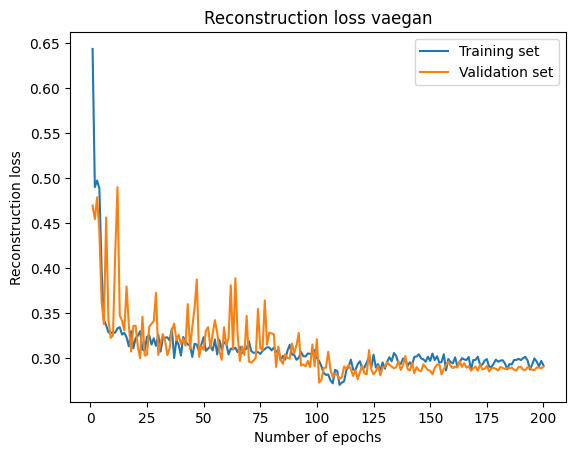

In [8]:
plt.plot(range(1,len(vaegan_trainer.train_losses[0])+1), vaegan_trainer.train_losses[0])
plt.plot(range(1,len(vaegan_trainer.train_losses[0])+1), vaegan_trainer.valid_losses[0])
plt.xlabel('Number of epochs')
plt.ylabel('Reconstruction loss')
plt.title('Reconstruction loss vaegan')
plt.legend(['Training set', 'Validation set'])
plot_name = 'RECON_LOSS_'+str(N_EPOCHS) + '_epochs_' + str(Z_DIM) + '_zdim.png'
path = EXPERIMENT_DIR_VAEGAN / plot_name

plt.savefig(path, dpi=200)

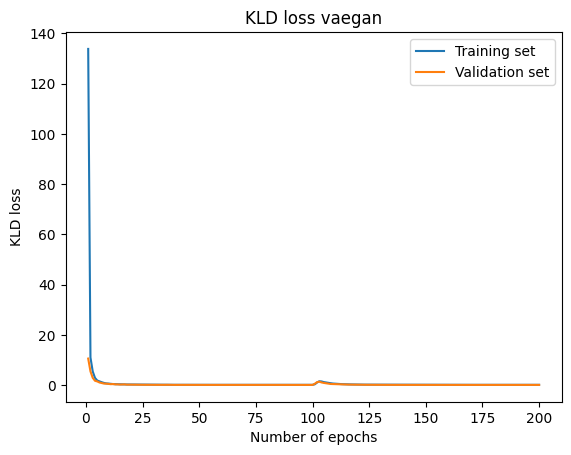

In [9]:
plt.plot(range(1,len(vaegan_trainer.train_losses[1])+1), vaegan_trainer.train_losses[1])
plt.plot(range(1,len(vaegan_trainer.train_losses[1])+1), vaegan_trainer.valid_losses[1])
plt.xlabel('Number of epochs')
plt.ylabel('KLD loss')
plt.title('KLD loss vaegan')
plt.legend(['Training set', 'Validation set'])
plot_name = 'KLD_LOSS_'+str(N_EPOCHS) + '_epochs_' + str(Z_DIM) + '_zdim.png'
path = EXPERIMENT_DIR_VAEGAN / plot_name

plt.savefig(path, dpi=200)

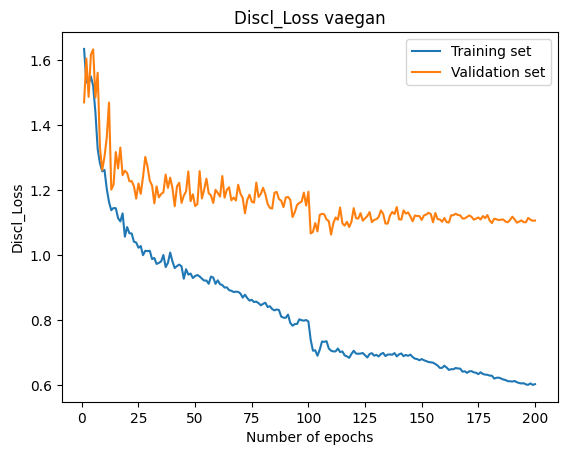

In [10]:
plt.plot(range(1,len(vaegan_trainer.train_losses[2])+1), vaegan_trainer.train_losses[2])
plt.plot(range(1,len(vaegan_trainer.train_losses[2])+1), vaegan_trainer.valid_losses[2])
plt.xlabel('Number of epochs')
plt.ylabel('Discl_Loss')
plt.title('Discl_Loss vaegan')
plt.legend(['Training set', 'Validation set'])
plot_name = 'Discl_Loss_'+str(N_EPOCHS) + '_epochs_' + str(Z_DIM) + '_zdim.png'
path = EXPERIMENT_DIR_VAEGAN / plot_name

plt.savefig(path, dpi=200)

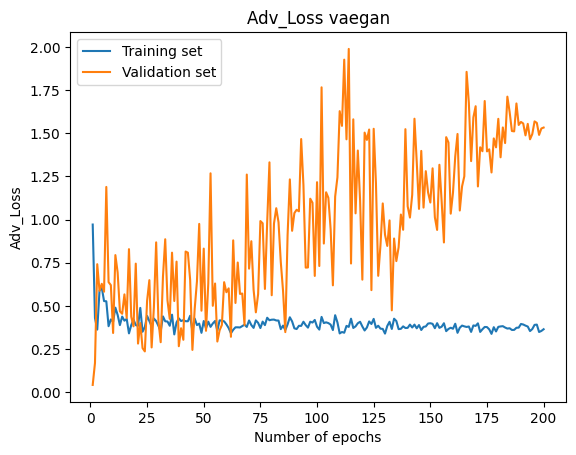

In [11]:
plt.plot(range(1,len(vaegan_trainer.train_losses[3])+1), vaegan_trainer.train_losses[3])
plt.plot(range(1,len(vaegan_trainer.train_losses[3])+1), vaegan_trainer.valid_losses[3])
plt.xlabel('Number of epochs')
plt.ylabel('Adv_Loss')
plt.title('Adv_Loss vaegan')
plt.legend(['Training set', 'Validation set'])
plot_name = 'Adv_Loss_'+str(N_EPOCHS) + '_epochs_' + str(Z_DIM) + '_zdim.png'
path = EXPERIMENT_DIR_VAEGAN / plot_name

plt.savefig(path, dpi=200)

In [21]:
seed = 0

vaegan_model = VAEGAN(z_dim=Z_DIM, l=2, spade=True).to(device)

EXPERIMENT_DIR_VAEGAN = Path(r"C:\Users\20182371\Documents\TUe\8DM20_CS_Medical_Imaging\DeepLearning_Project\progress_vaegan\200_epochs_256_zdim_final")
model_dir = EXPERIMENT_DIR_VAEGAN / "model.pth"
vaegan_model.load_state_dict(torch.load(model_dir))
vaegan_model.eval()

patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]

train_size = 13 

train_indx, valid_indx = train_test_split(patients, random_state=seed, train_size=train_size)

partition = {
    "train": train_indx,
    "validation": valid_indx,
}

training_set = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE, empty_masks = False)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)




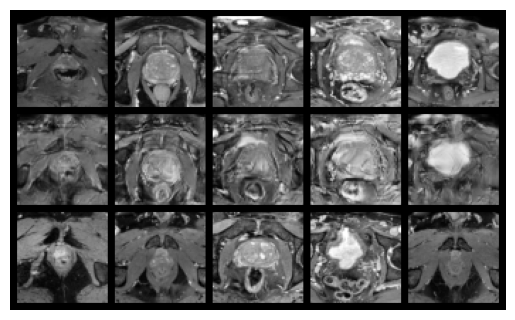

In [31]:
first_indx = np.random.choice(np.arange(len(train_loader.dataset)), size=5, replace=False)
second_indx = np.random.choice(np.arange(len(train_loader.dataset)), size=5, replace=False)
for i in range(len(second_indx)):
    if second_indx[i] > len(train_loader.dataset): 
        second_indx[i] = len(train_loader.dataset)-1

first_image_t , first_mask_t = train_loader.dataset[first_indx]
second_image_t, second_mask_t = train_loader.dataset[second_indx]
first_image_t = first_image_t.to(device)
first_mask_t = first_mask_t.to(device)
second_image_t = second_image_t.to(device)
second_mask_t = second_mask_t.to(device)


mu_first, logvar_first = vaegan_model.encoder(first_image_t)
latent_z_first = utils.sample_z(mu_first, logvar_first)
            
mu_second, logvar_second = vaegan_model.encoder(second_image_t)
latent_z_second = utils.sample_z(mu_second, logvar_second)
weight = 0.5
gen_latent_z = latent_z_first + weight*(latent_z_second - latent_z_first)
generations  = vaegan_model.generator(gen_latent_z, first_mask_t)

img_grid = make_grid(
                torch.cat([
                    first_image_t.cpu(),
                    generations.cpu(),
                    second_image_t.cpu()
                ]), 
                nrow=5, 
                padding=5, 
                pad_value=-1, )
    
plt.imshow(img_grid.numpy()[0], cmap = "gray") #[0] / 2.0 + 0.5
plt.axis("off")
plt.imsave(EXPERIMENT_DIR_VAEGAN / f"interpolated_generations_{weight}.png", img_grid.numpy()[0], cmap = "gray")

In [ ]:
first_indx = np.random.choice(np.arange(len(train_loader.dataset)), size=1, replace=False)
second_indx = first_indx+10

first_image_t , first_mask_t = train_loader.dataset[first_indx]
second_image_t, second_mask_t = train_loader.dataset[second_indx]
first_image_t = first_image_t.to(device)
first_mask_t = first_mask_t.to(device)
second_image_t = second_image_t.to(device)
second_mask_t = second_mask_t.to(device)


mu_first, logvar_first = vaegan_model.encoder(first_image_t)
latent_z_first = utils.sample_z(mu_first, logvar_first)
            
mu_second, logvar_second = vaegan_model.encoder(second_image_t)
latent_z_second = utils.sample_z(mu_second, logvar_second)

images = []
for i in range(0,21,1):
    gen_latent_z = latent_z_first + (i/20)*(latent_z_second - latent_z_first)
    generations  = vaegan_model.generator(gen_latent_z, first_mask_t) 
    
    images.append(np.array(generations.squeeze().detach().cpu()))

    
imageio.mimsave(EXPERIMENT_DIR_VAEGAN / 'generations.gif', images, fps=10)

#did not know how to display a gif in jupyter notebook so the code below is from ChatGTP 
from IPython.display import HTML
from base64 import b64encode

gif = open(EXPERIMENT_DIR_VAEGAN / 'generations.gif','rb').read()
#HTML(f"<img src='data:image/gif;base64,{b64encode(gif).decode('utf-8')}' />")
HTML(f"<img src='data:image/gif;base64,{b64encode(gif).decode('utf-8')}' style='width:600px;height:450px;'/>")